# Import and load Detectron2 and libraries

In [2]:
!nvidia-smi

Tue May 26 12:04:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:04:00.0 Off |                  N/A |
| 18%   37C    P0    71W / 250W |      0MiB / 12212MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 980 Ti  Off  | 00000000:05:00.0 Off |                  N/A |
| 22%   30C    P8    15W / 250W |   6016MiB /  6083MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import torch, torchvision
torch.cuda.set_device(0)
print(f'Torch version: {torch.__version__}')

Torch version: 1.4.0


In [8]:
# Restart runtime.
%load_ext autoreload
%autoreload 2

# Setup logger detectron2.
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common detectron2 utilities.
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer, LOFARTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LOFAREvaluator
from detectron2 import model_zoo ##### Auke: Is this necessary?


# Import some common libraries.
import numpy as np
from sys import argv
from cv2 import imread
import random
import os
import pickle
from operator import itemgetter
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load data

In [5]:
# Setup dataset.
DATASET_NAME= "auke_set_13"
DATASET_PATH = f"/data/s1594443/data/frcnn_images_DR1/auke_set_13/LGZ_COCOstyle/annotations/"

In [9]:
# Setup cfg.
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/v8_faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.VAL = (f"{DATASET_NAME}_val",)
cfg.DATASETS.TEST = (f"{DATASET_NAME}_test",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.OUTPUT_DIR = './output/v9'
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = None #"https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,"model_0014999.pth")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0003  # pick a good LR
cfg.SOLVER.MAX_ITER = 100 # iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

In [10]:
def get_lofar_dicts(annotation_filepath):
    with open(annotation_filepath, "rb") as f:
        dataset_dicts = pickle.load(f)
    new_data = []
    for i in range(len(dataset_dicts)):
        for ob in dataset_dicts[i]['annotations']:
            ob['bbox_mode'] = BoxMode.XYXY_ABS
        if dataset_dicts[i]['file_name'].endswith('_rotated0deg.png'):
            new_data.append(dataset_dicts[i])
    return new_data

In [11]:
# Register data inside detectron
for d in ["train", "val", "test"]:
    DatasetCatalog.register(d, 
                            lambda d=d: get_lofar_dicts(os.path.join(DATASET_PATH,f"VIA_json_{d}.pkl")))
    MetadataCatalog.get(d).set(thing_classes=["radio_source"])
lofar_metadata = MetadataCatalog.get("train")

In [12]:
for d in ["train", "val", "test"]:
    DatasetCatalog.register(f"{DATASET_NAME}_" + d, 
                            lambda d=d: get_lofar_dicts(os.path.join(DATASET_PATH,f"VIA_json_{d}.pkl")))
    MetadataCatalog.get(f"{DATASET_NAME}_" + d).set(thing_classes=["radio_source"])
lofar_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")

# 2. Inspect data.

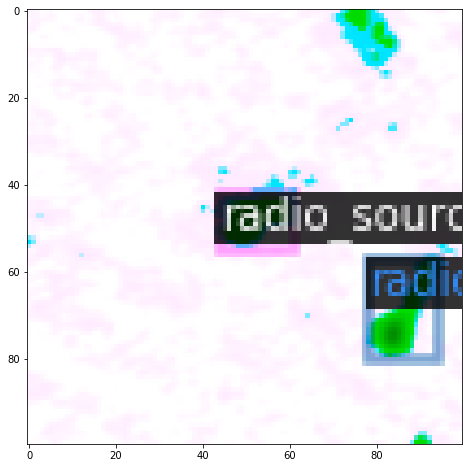

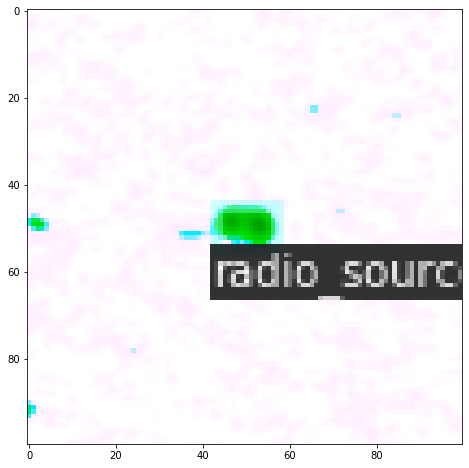

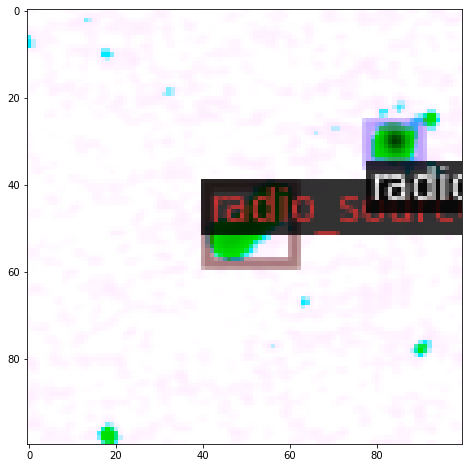

In [13]:
# Sample and plot input data as sanity check.
dataset_dicts = get_lofar_dicts(os.path.join(DATASET_PATH,"VIA_json_train.pkl"))
for i, d in enumerate(random.sample(dataset_dicts, 3)):
    img = imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=lofar_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    a= vis.get_image()[:, :, ::-1]
    plt.figure(figsize=(8,8))
    plt.imshow(a)
    plt.savefig(os.path.join(cfg.OUTPUT_DIR,f"random_input_example_for_sanity_check_{i}"))
    plt.show()
    plt.close()

# 3. Train data.

In [21]:
# Comment from Rafaël copies from train_lofar.py

# # Train mode

# To implement the LOFAR relevant metrics I changed
# DefaultTrainer into LOFARTrainer
# where the latter calls LOFAREvaluator within build_hooks instead of the default evaluator
# this works for the after the fact test eval
# for train eval those things are somewhere within a model 
# specifically a model that takes data and retuns a dict of losses

In [14]:
# Load model.
trainer = LOFARTrainer(cfg) 

[05/26 12:08:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/26 12:08:35 d2.data.build]: Removed 0 images with no usable annotations. 55 images left.
[05/26 12:08:35 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| radio_source | 103          |
|              |              |
[05/26 12:08:35 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(600,), max_size=600, sample_style='choice'), RandomFlip()]
[05/26 12:08:35 d2.data.build]: Using training sampler TrainingSampler


In [15]:
# Make directory and set up model path.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
pretrained_model_path = os.path.join(cfg.OUTPUT_DIR,"model_final.pth")

In [16]:
if os.path.exists(pretrained_model_path):
    print(f'Pretrained model path exists: {pretrained_model_path}')
    cfg.MODEL.WEIGHTS = pretrained_model_path
    trainer.resume_or_load(resume=True)
else:
    print(f'Pretrained model path does not exist. Will not resume training.')
    trainer.resume_or_load(resume=False)

Pretrained model path does not exist. Will not resume training.


In [17]:
# Start training.
#torch.cuda.set_device(0)
trainer.train()

[05/26 12:08:48 d2.engine.train_loop]: Starting training from iteration 0
[05/26 12:09:05 d2.utils.events]: eta: 0:01:07  iter: 19  total_loss: 1.068  loss_cls: 0.220  loss_box_reg: 0.008  loss_rpn_cls: 0.527  loss_rpn_loc: 0.475  time: 0.8254  data_time: 0.0137  lr: 0.000006  max_mem: 3441M
[05/26 12:09:21 d2.utils.events]: eta: 0:00:50  iter: 39  total_loss: 0.378  loss_cls: 0.086  loss_box_reg: 0.002  loss_rpn_cls: 0.175  loss_rpn_loc: 0.134  time: 0.8289  data_time: 0.0074  lr: 0.000012  max_mem: 3441M
[05/26 12:09:38 d2.utils.events]: eta: 0:00:33  iter: 59  total_loss: 0.239  loss_cls: 0.044  loss_box_reg: 0.002  loss_rpn_cls: 0.119  loss_rpn_loc: 0.074  time: 0.8271  data_time: 0.0075  lr: 0.000018  max_mem: 3441M
[05/26 12:09:55 d2.utils.events]: eta: 0:00:17  iter: 79  total_loss: 0.210  loss_cls: 0.036  loss_box_reg: 0.004  loss_rpn_cls: 0.096  loss_rpn_loc: 0.038  time: 0.8284  data_time: 0.0069  lr: 0.000024  max_mem: 3441M
<class 'list'>
[05/26 12:10:12 d2.data.build]: Dis

OrderedDict([('bbox',
              {'assoc_single_fail_fraction': 0.0,
               'assoc_multi_fail_fraction': 1.0,
               'unassoc_single_fail_fraction': 0.0,
               'unassoc_multi_fail_fraction': 0.0,
               'correct_catalogue': 0.8})])

In [20]:
# Comment from Rafaël copied from train_lofar.py
'''
# Look at training curves in tensorboard:
get_ipython().run_line_magic('load_ext', 'tensorboard')
# %tensorboard --logdir output --host "0.0.0.0" --port 6006
get_ipython().run_line_magic('tensorboard', '--logdir output  --port 6006')
# In local command line input 
#ssh -X -N -f -L localhost:8890:localhost:6006 tritanium
# Then open localhost:8890 to see tensorboard
'''

'\n# Look at training curves in tensorboard:\nget_ipython().run_line_magic(\'load_ext\', \'tensorboard\')\n# %tensorboard --logdir output --host "0.0.0.0" --port 6006\nget_ipython().run_line_magic(\'tensorboard\', \'--logdir output  --port 6006\')\n# In local command line input \n#ssh -X -N -f -L localhost:8890:localhost:6006 tritanium\n# Then open localhost:8890 to see tensorboard\n'

# 4. Inference mode.

In [22]:
# Done training. Enter inference mode

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


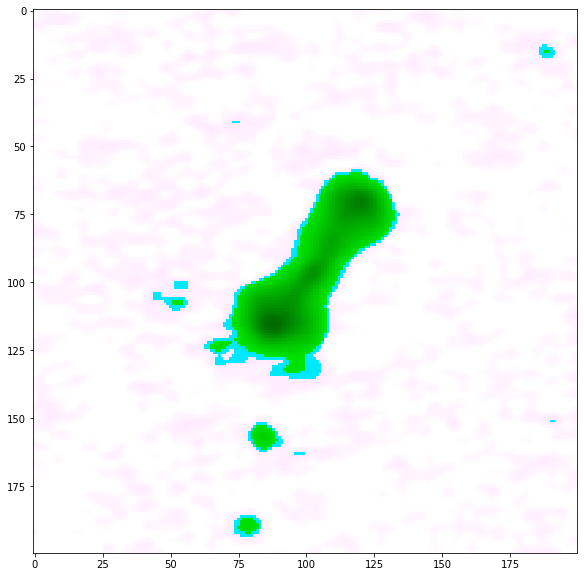

Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


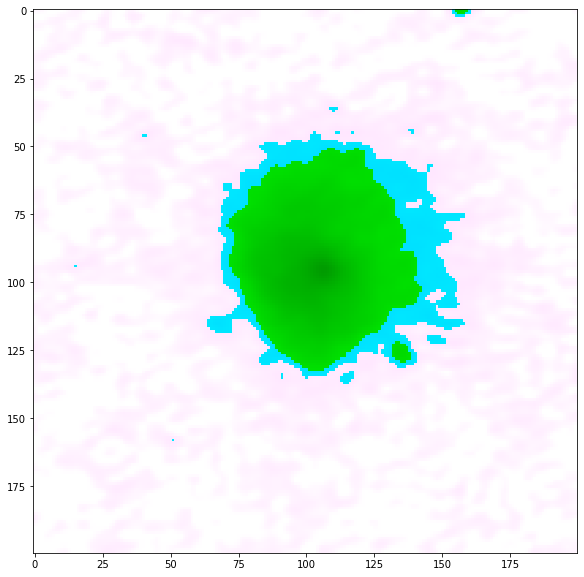

Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


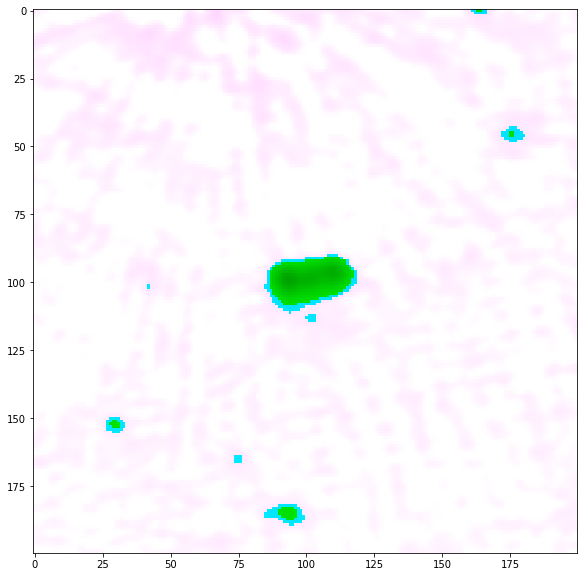

In [25]:
#Sample and plot predicted data as sanity check
aap = get_lofar_dicts(os.path.join(DATASET_PATH,f"VIA_json_val.pkl"))
for d in random.sample(aap, 3):
    if not d["file_name"].endswith('_rotated0deg.png'):
        continue
    im = imread(d["file_name"])
    outputs = predictor(im)
    print(outputs["instances"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=lofar_metadata, 
                   scale=1, 
                  instance_mode=ColorMode.IMAGE #_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.savefig(os.path.join(cfg.OUTPUT_DIR,f"random_prediction_example_for_sanity_check_{i}"))
    plt.show()
    plt.close()

In [26]:
# Evaluate performance for validation set
# returns a torch DataLoader, that loads the given detection dataset, 
# with test-time transformation and batching.
# Val_loader produces inputs that can enter the model for inference, 
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
val_loader = build_detection_test_loader(cfg, f"val")
evaluator = LOFAREvaluator(f"val", cfg.OUTPUT_DIR, distributed=True)
predictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=True)

[05/26 12:22:51 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| radio_source | 27           |
|              |              |
[05/26 12:22:51 d2.evaluation.evaluator]: Start inference on 17 images
[05/26 12:22:52 d2.evaluation.evaluator]: Inference done 11/17. 0.1501 s / img. ETA=0:00:00
[05/26 12:22:53 d2.evaluation.evaluator]: Total inference time: 0:00:01.780026 (0.148335 s / img per device, on 1 devices)
[05/26 12:22:53 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.142852 s / img per device, on 1 devices)
We have 13 single comp cutouts and 4 multi
Baseline assumption cat is 76.5% correct
Trained cat is 76.5% correct
0.00% improvement
OrderedDict([('bbox', {'assoc_single_fail_fraction': 0.0, 'assoc_multi_fail_fraction': 1.0, 'unassoc_single_fail_fraction': 0.0, 'unassoc_multi_fail_fraction': 0.0, 'correct_catalogue': 0.7647058823529411})])
[05/26 12:22:53 d2.evaluation.evalu

In [27]:
# Comment from Rafaël copied from train_lofar.py
"""
print("Evaluate performance for test set")
# returns a torch DataLoader, that loads the given detection dataset, 
# with test-time transformation and batching.
# Val_loader produces inputs that can enter the model for inference, 
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
val_loader = build_detection_test_loader(cfg, "test")
evaluator = LOFAREvaluator("test", cfg.OUTPUT_DIR, distributed=True)
predictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=True)
"""

'\nprint("Evaluate performance for test set")\n# returns a torch DataLoader, that loads the given detection dataset, \n# with test-time transformation and batching.\n# Val_loader produces inputs that can enter the model for inference, \n# the results of which can be evaluated by the evaluator\n# The return value is that which is returned by evaluator.evaluate()\nval_loader = build_detection_test_loader(cfg, "test")\nevaluator = LOFAREvaluator("test", cfg.OUTPUT_DIR, distributed=True)\npredictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=True)\n'